In [5]:
%load_ext autoreload
%autoreload 2
%reload_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [18]:
import numpy as np
import scipy.stats as stats
from scipy import interpolate
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib as mpl
import pandas as pd
from tabulate import tabulate


from bgspy.models import BGSModel 
from bgspy.genome import Genome
from bgspy.data import GenomeData, get_accessible_from_seqs
from bgspy.likelihood import BGSEstimator

In [ ]:
plt.rcParams['figure.figsize'] = [8, 4]
plt.rcParams['figure.dpi'] = 200

In [8]:
g = Genome('hg38', seqlens_file="../data/annotation/hg38_seqlens.tsv", chroms=[f'chr{c}' for c in list(range(1, 3)) + list(range(4, 23))])
g.load_annot("../data/annotation/conserved_phastcons_thresh0.bed.gz")
g.load_recmap("../data/annotation/hapmap_genetic_map.txt")

load_bed_annotation(): ignored chr3
ignoring HapMap header...
parsing recmap as HapMap formatted (chrom, end, rate)
RecMap._readmap() ignored chrX, chr3


In [9]:
gd = GenomeData(g)
gd.load_counts_dir('../data/h1kg/hg1k_counts/')
gd.load_neutral_masks('../data/annotation/neutral_phastcons_genes_with_introns.bed.gz')
gd.load_accessibile_masks('../data/annotation/no_centro.bed')

In [10]:
gd.stats()

{'chr1': (0.6437419477373434, 0.9783094569056748),
 'chr2': (0.5870489628151874, 0.9744006372688843),
 'chr4': (0.5932240306216314, 0.9705595610178201),
 'chr5': (0.5797625887774984, 0.9597880907296792),
 'chr6': (0.5797259005786911, 0.9642869644510512),
 'chr7': (0.6579516885563214, 0.9623460832612318),
 'chr8': (0.6118077615115524, 0.9586602150512149),
 'chr9': (0.6450291885058012, 0.961703740468648),
 'chr10': (0.6283062090688115, 0.9581456808637165),
 'chr11': (0.6352933157215227, 0.9496619287733763),
 'chr12': (0.6272914737717847, 0.9504784490876701),
 'chr13': (0.6201949352598828, 0.9615264647906644),
 'chr14': (0.6542182139077045, 0.9616978924442815),
 'chr15': (0.693987948311888, 0.9509761573619855),
 'chr16': (0.6381502671982755, 0.9435455674996038),
 'chr17': (0.6403107801499688, 0.9195267123331354),
 'chr18': (0.5983902238162843, 0.8992202446372572),
 'chr19': (0.697669622046724, 0.899347663678441),
 'chr20': (0.6157114886751504, 0.8960340351672169),
 'chr21': (0.68593020040

In [11]:
gd.load_fasta('../data/annotation/hg38.fa.gz')

In [12]:
wind = 1e6

In [13]:
bins, pi = gd.bin_pi(width=wind, filter_neutral=True, filter_accessible=True)

using neutral masks...
using accessibility masks...
using neutral masks...
using accessibility masks...
using neutral masks...
using accessibility masks...
using neutral masks...
using accessibility masks...
using neutral masks...
using accessibility masks...
using neutral masks...
using accessibility masks...
using neutral masks...
using accessibility masks...
using neutral masks...
using accessibility masks...
using neutral masks...
using accessibility masks...
using neutral masks...
using accessibility masks...
using neutral masks...
using accessibility masks...
using neutral masks...
using accessibility masks...
using neutral masks...
using accessibility masks...
using neutral masks...
using accessibility masks...
using neutral masks...
using accessibility masks...
using neutral masks...
using accessibility masks...
using neutral masks...
using accessibility masks...
using neutral masks...
using accessibility masks...
using neutral masks...
using accessibility masks...
using neutra

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


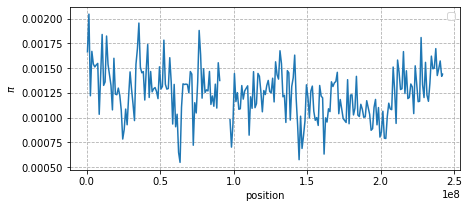

In [14]:
fig, ax = plt.subplots(figsize=(7, 3))

x, y = pi['chr2'].pairs
ax.plot(x, y)

ax.set_xlabel('position')
ax.set_ylabel('$\pi$')
ax.legend()
ax.grid(linestyle='dashed')

## B Maps

In [15]:
#pkl_b_file = '../data/bmaps/bgspy/bmap_hg38_6x4grid_10000step_10kN_mergedfeatures_old.pkl'
pkl_b_file = '../data/bmaps/bgspy/bmap_hg38_6x5grid_10000step_10kN_mergedfeatures.pkl'
pkl_b_file = '../data/bmaps/bgspy/bmap_hg38_6x5grid_10000step_10kN_genomiconly.pkl'
m = BGSModel.load(pkl_b_file)
g = m.genome

In [16]:
bins, Y = gd.bin_reduce(wind, merge=True, filter_accessible=True, filter_neutral=True)

using neutral masks...
using accessibility masks...
using neutral masks...
using accessibility masks...
using neutral masks...
using accessibility masks...
using neutral masks...
using accessibility masks...
using neutral masks...
using accessibility masks...
using neutral masks...
using accessibility masks...
using neutral masks...
using accessibility masks...
using neutral masks...
using accessibility masks...
using neutral masks...
using accessibility masks...
using neutral masks...
using accessibility masks...
using neutral masks...
using accessibility masks...
using neutral masks...
using accessibility masks...
using neutral masks...
using accessibility masks...
using neutral masks...
using accessibility masks...
using neutral masks...
using accessibility masks...
using neutral masks...
using accessibility masks...
using neutral masks...
using accessibility masks...
using neutral masks...
using accessibility masks...
using neutral masks...
using accessibility masks...
using neutra

In [17]:
B = np.concatenate([m.BScores.bin_means(bins).B[c] for c in bins.bins.keys()], axis=0)
Bp = np.concatenate([m.BpScores.bin_means(bins).B[c] for c in bins.bins.keys()], axis=0)

In [20]:
mleBp = BGSEstimator(m.w, m.t, Bp, (-5, -1))
mleBp.fit(Y, 1)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:19<00:00, 19.14s/it]

all 1/1 converged


MLE (interpolated w): 6 x 5 x 3
  w grid: [1.000e-11 6.310e-11 3.981e-10 2.512e-09 1.585e-08 1.000e-07] (before interpolation)
  t grid: [1.e-05 1.e-04 1.e-03 1.e-02 1.e-01]
MLEs:
  pi0 = 0.001679
  W = [[3.856e-08 4.890e-09 1.393e-11]
    [1.000e-11 1.000e-11 1.000e-11]
    [1.000e-11 1.000e-11 1.000e-11]
    [1.000e-11 1.000e-11 1.000e-11]
    [1.000e-11 1.000e-11 1.573e-08]]
 negative log-likelihood: 913812918851.02

In [24]:
mleBp.to_npz('data/hg38_test_data.npz')

FileNotFoundError: [Errno 2] No such file or directory: 'data/hg38_test_data.npz'

In [86]:
from bgspy.likelihood import negll_numba, negll_jax, negll_numba_reparam, logit, inverse_logit

In [53]:
from scipy.optimize import dual_annealing, minimize
from functools import partial

In [136]:
mleB = InterpolatedMLE(m.w, m.t, B, (-5, -1))
mleBp = InterpolatedMLE(m.w, m.t, Bp, (-5, -1))

In [23]:
import nlopt
from functools import partial
bounds = np.array(mleBp.bounds())

In [103]:
from bgspy.likelihood import negll_numba, negll_jax #negll_numba_reparam, logit, inverse_logit
dual_annealing(partial(negll_numba, Y=Y, logB=Bp, w=m.w), mleBp.bounds())

     fun: 913581543990.2261
 message: ['Maximum number of iteration reached']
    nfev: 74518
    nhev: 0
     nit: 1000
    njev: 2501
  status: 0
 success: True
       x: array([1.85623078e-03, 2.15404094e-08, 1.76376789e-08, 1.54806591e-08,
       9.74644062e-11, 4.53929004e-10, 4.91323533e-10, 1.78693536e-10,
       1.11083109e-10, 9.74644062e-11, 6.87806954e-10, 3.02551005e-10,
       3.56787871e-11, 1.15666406e-09, 4.26532138e-09, 7.96584585e-09])

In [111]:
opt2 = dual_annealing(partial(negll_numba, Y=Y, logB=Bp, w=m.w), mleBp.bounds())

In [113]:
opt2.x[1:].reshape((5,3)) / opt2.x[1:].reshape((5,3)).sum(axis=0)

array([[0.83800999, 0.86939085, 0.76398002],
       [0.01027858, 0.00521702, 0.00948923],
       [0.00493103, 0.00356541, 0.01112151],
       [0.11185774, 0.00780003, 0.0074208 ],
       [0.03492267, 0.11402669, 0.20798844]])

In [110]:
opt.x[1:].reshape((5,3)) / opt.x[1:].reshape((5,3)).sum(axis=0)

array([[0.91037465, 0.77458246, 0.64312564],
       [0.00411919, 0.0199349 , 0.02041145],
       [0.00755223, 0.00487836, 0.00404904],
       [0.02906918, 0.01328694, 0.00148223],
       [0.04888475, 0.18731734, 0.33093163]])

In [254]:
from scipy.optimize import basinhopping, direct

ImportError: cannot import name 'direct' from 'scipy.optimize' (/home/vsb/miniconda3/envs/bprime/lib/python3.8/site-packages/scipy/optimize/__init__.py)

In [259]:
from bgspy.likelihood import BGSMLE
mleBp = BGSMLE(m.w, m.t, Bp, (-5, -1))
mleBp.to_npz('../data/human_fitdata.npz')

[autoreload of bgspy.likelihood failed: Traceback (most recent call last):
  File "/home/vsb/miniconda3/envs/bprime/lib/python3.8/site-packages/IPython/extensions/autoreload.py", line 257, in check
    superreload(m, reload, self.old_objects)
  File "/home/vsb/miniconda3/envs/bprime/lib/python3.8/site-packages/IPython/extensions/autoreload.py", line 455, in superreload
    module = reload(module)
  File "/home/vsb/miniconda3/envs/bprime/lib/python3.8/importlib/__init__.py", line 169, in reload
    _bootstrap._exec(spec, module)
  File "<frozen importlib._bootstrap>", line 604, in _exec
  File "<frozen importlib._bootstrap_external>", line 839, in exec_module
  File "<frozen importlib._bootstrap_external>", line 976, in get_code
  File "<frozen importlib._bootstrap_external>", line 906, in source_to_code
  File "<frozen importlib._bootstrap>", line 219, in _call_with_frames_removed
  File "/home/vsb/projects/bprime/bgspy/likelihood.py", line 327
    np.savez(filename, logB=self.logB, w=

ImportError: cannot import name 'BGSMLE' from 'bgspy.likelihood' (/home/vsb/projects/bprime/bgspy/likelihood.py)

In [250]:
class MyBounds:
    def __init__(self, xmin, xmax):
        self.xmin = np.array(xmin)
        self.xmax = np.array(xmax)
    def __call__(self, **kwargs):
        x = kwargs["x_new"].flatten()
        tmax = bool(np.all(x <= self.xmax))
        tmin = bool(np.all(x >= self.xmin))
        accept = (tmax and tmin)
        return accept

In [251]:
mleBp = InterpolatedMLE(m.w, m.t, Bp, (-5, -1))

In [252]:
bh = basinhopping(partial(negll_numba, Y=Y, logB=Bp, w=m.w), mleBp.random_start(), niter=1000, accept_test=MyBounds(*mleBp.bounds(paired=False)))

In [253]:
bh

                        fun: nan
 lowest_optimization_result:       fun: nan
 hess_inv: array([[ 6.93852196e-16,  8.63689643e-22,  2.09499936e-20,
         7.96962961e-21,  5.76051110e-22,  2.59186509e-21,
         9.12403306e-23,  6.14645956e-22,  1.37235405e-22,
         1.03031473e-22,  3.78098836e-22,  8.74823819e-23,
         6.63840085e-23,  3.04346464e-22,  7.06163615e-23,
         5.36459041e-23],
       [ 8.63689643e-22,  9.01875554e-01,  2.28627356e-28,
         2.35592887e-21, -4.70826243e-03, -2.97370209e-01,
        -7.45738379e-04, -5.02371128e-03, -1.12167183e-03,
        -8.42111413e-04, -3.09033090e-03, -7.15023381e-04,
        -5.42579170e-04, -2.48752758e-03, -5.77171637e-04,
        -4.38466293e-04],
       [ 2.09499936e-20,  6.27952498e-27,  1.64104127e-22,
         1.95347044e-23, -3.08568438e-25,  3.94840123e-26,
        -4.93916754e-26, -3.34410145e-25, -7.41719315e-26,
        -5.55241507e-26, -2.02595610e-25, -4.84320494e-26,
        -3.55580193e-26, -1.652034

In [101]:
np.round(inverse_logit(opt.x), 5)

array([0.0118, 0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    ,
       0.    , 0.    , 2.0574, 0.    , 0.    , 0.    , 0.    , 0.    ])

In [99]:
np.round(inverse_logit(opt.x), 5)

array([0.0118, 0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    ,
       0.    , 0.    , 2.0574, 0.    , 0.    , 0.    , 0.    , 0.    ])

In [78]:
start = mleBp.random_start()
start, inverse_logit(logit(start))

(array([[1.96788018e-02],
        [1.15410244e-08],
        [4.98654578e-08],
        [3.79276924e-08],
        [8.54618007e-08],
        [2.52703357e-08],
        [4.54989090e-08],
        [3.31008840e-08],
        [2.58978536e-09],
        [2.29748500e-08],
        [1.16931251e-08],
        [6.46119064e-08],
        [7.01185330e-08],
        [4.42712796e-08],
        [9.68091759e-08],
        [8.76177665e-08]]),
 array([[5.39868456e-03],
        [3.10385955e-09],
        [1.34108878e-08],
        [1.02003279e-08],
        [2.29842201e-08],
        [6.79624017e-09],
        [1.22365418e-08],
        [8.90219908e-09],
        [6.96500558e-10],
        [6.17888897e-09],
        [3.14476573e-09],
        [1.73768191e-08],
        [1.88577793e-08],
        [1.19063814e-08],
        [2.60359999e-08],
        [2.35640487e-08]]))

In [71]:
logit(inverse_logit(10))

FloatingPointError: invalid value encountered in log

In [41]:
opt = nlopt.opt(nlopt.LN_COBYLA, bounds.shape[0])
opt.set_lower_bounds(bounds[:, 0])
opt.set_upper_bounds(bounds[:, 1])
opt.set_ftol_rel(1e-6)
opt.set_min_objective(partial(negll_numba, Y=Y, logB=Bp, w=m.w))
    

In [42]:
xmin = opt.optimize(mleBp.random_start().squeeze())


TypeError: too many arguments: expected 4, got 5

In [37]:
mleBp.random_start()

array([[4.20047694e-02],
       [3.04137848e-08],
       [5.07455134e-08],
       [4.19268564e-08],
       [6.51920269e-08],
       [7.87128869e-08],
       [8.71187843e-08],
       [4.50425356e-08],
       [1.31658231e-09],
       [9.97755719e-08],
       [3.98180223e-08],
       [4.16922842e-08],
       [8.44181638e-08],
       [8.36453482e-08],
       [3.13555809e-08],
       [6.89475442e-08]])

In [21]:
opt = dual_annealing(partial(negll_numba, Y=Y, logB=Bp, w=m.w), mleBp.bounds())

In [22]:
opt.x[1:].reshape((4, 4)) / opt.x[1:].reshape((4, 4)).sum(axis=0)

array([[0.1405147 , 0.16971764, 0.33126929, 0.93398154],
       [0.1405147 , 0.16971764, 0.16194029, 0.00313422],
       [0.35888522, 0.16971764, 0.16194029, 0.011516  ],
       [0.36008538, 0.49084709, 0.34485014, 0.05136824]])

In [534]:
minimize(partial(negll_numba, Y=Y, logB=Bp, w=m.w), x0=mleBp.random_start(), bounds=mleBp.bounds())

      fun: 914444751289.0457
 hess_inv: <17x17 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 1.04666443e+11,  1.99487436e+14,  2.12511690e+14,  8.43684245e+13,
       -1.46525683e+16,  1.42718505e+16,  1.58525854e+16,  9.53019339e+15,
        1.57227271e+19,  4.81815830e+15,  5.46929882e+15,  4.64517012e+15,
        4.73343656e+18,  1.43431717e+15,  1.61283790e+15,  1.80634758e+15,
        2.53781955e+18])
  message: 'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 2808
      nit: 21
     njev: 156
   status: 0
  success: True
        x: array([2.08933666e-03, 5.72076993e-08, 2.81645161e-09, 3.52839182e-08,
       7.81212389e-10, 3.01913078e-08, 4.48277737e-09, 3.82157398e-10,
       1.00000000e-10, 9.67908218e-08, 2.66827512e-09, 3.23196776e-09,
       1.00000000e-10, 1.03386611e-08, 4.00778752e-10, 5.78656879e-08,
       5.12570035e-09])

In [23]:
import jax

In [27]:
x = opt.x

In [29]:
jax.device_put(x)

DeviceArray([1.7493211e-03, 1.0000000e-10, 1.0000000e-10, 2.0456262e-10,
             2.9799516e-08, 1.0000000e-10, 1.0000000e-10, 1.0000000e-10,
             1.0000000e-10, 2.5540761e-10, 1.0000000e-10, 1.0000000e-10,
             3.6742814e-10, 2.5626173e-10, 2.8921396e-10, 2.1294895e-10,
             1.6389496e-09], dtype=float32)

In [31]:
hess = jax.hessian(partial(negll_jax, Y=Y, logB=Bp[:, :, :, 3][..., None], w=m.w))
jac = jax.jacobian(partial(negll_jax, Y=Y, logB=Bp[:, :, :, 3][..., None], w=m.w))

In [43]:
jac(x[[0, 4, 8, 12, 16]])

DeviceArray([ 1.3294596e+11, -4.4904068e+14, -7.4450166e+16,
             -1.1576086e+17, -1.1415057e+17], dtype=float32)

In [ ]:
opt.x

In [ ]:
hess(opt.x)

In [47]:
#np.linalg.inv(opt.hess_inv.todense())

In [508]:
opt1 = np.array([1.73863240e-03, 1.00000000e-10, 1.00000000e-10, 1.00000000e-10,
       3.47867841e-08, 1.00000000e-10, 1.00000000e-10, 1.00000000e-10,
       1.00000000e-10, 2.24753049e-10, 1.00000000e-10, 1.00000000e-10,
       3.78415954e-10, 2.70111568e-10, 2.14710220e-10, 2.27533744e-10,
       1.10736610e-09])
opt2 = np.array([1.81252707e-03, 2.20388268e-10, 2.83584787e-10, 2.55601873e-10,
       3.37011217e-08, 1.00000000e-10, 1.00000000e-10, 1.00000000e-10,
       1.00000000e-10, 2.60632369e-10, 1.00000000e-10, 1.00000000e-10,
       2.22480467e-10, 2.26802133e-10, 1.01064185e-10, 2.50947480e-10,
       1.94755219e-09])

In [514]:
b = opt2[1:].reshape((4, 4))
b / b.sum(axis=0)

array([[0.2728176 , 0.48505137, 0.36176082, 0.93689297],
       [0.12378953, 0.1710428 , 0.14153293, 0.00278001],
       [0.32263558, 0.1710428 , 0.14153293, 0.00618497],
       [0.28075729, 0.17286302, 0.35517332, 0.05414205]])

In [476]:
wopt = opt.x[1:].reshape((4, 4))
opt.x[0]

0.0018125270687939761

In [477]:
wopt / wopt.sum(axis=0)

array([[0.2728176 , 0.48505137, 0.36176082, 0.93689297],
       [0.12378953, 0.1710428 , 0.14153293, 0.00278001],
       [0.32263558, 0.1710428 , 0.14153293, 0.00618497],
       [0.28075729, 0.17286302, 0.35517332, 0.05414205]])

In [517]:
m.t
np.logspace(-5, -1, 5)

array([1.e-05, 1.e-04, 1.e-03, 1.e-02, 1.e-01])

In [488]:
opt

     fun: 3.0288272562537395e+17
 message: ['Maximum number of iteration reached']
    nfev: 66401
    nhev: 0
     nit: 1000
    njev: 1800
  status: 0
 success: True
       x: array([1.81252707e-03, 2.20388268e-10, 2.83584787e-10, 2.55601873e-10,
       3.37011217e-08, 1.00000000e-10, 1.00000000e-10, 1.00000000e-10,
       1.00000000e-10, 2.60632369e-10, 1.00000000e-10, 1.00000000e-10,
       2.22480467e-10, 2.26802133e-10, 1.01064185e-10, 2.50947480e-10,
       1.94755219e-09])

In [409]:
Bp.shape, B.shape

((5363, 6, 4, 4), (5363, 6, 4, 4))

In [232]:
#B = m.BScores.bin_means(bins).B['chr10']
#Bp = m.BpScores.bin_means(bins).B['chr10']

In [136]:
mleB = InterpolatedMLE(m.w, m.t, B, (-5, -1))
mleBp = InterpolatedMLE(m.w, m.t, Bp, (-5, -1))

In [ ]:
mleB.fit(Y, nruns=200, ncores=70)
mleBp.fit(Y, nruns=200, ncores=70)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [07:42<00:00,  2.31s/it]


  5%|███████████▋                                                                                                                                                                                                                              | 10/200 [01:35<24:29,  7.73s/it]

In [67]:
mleB.summary(), mleBp.summary()

π0 = 0.001960002920839888
feature 0:
  w(1e-05) = 1e-11
  w(0.0001) = 1e-11
  w(0.001) = 1e-11
  w(0.01) = 7.975e-10
  w(0.1) = 5.329e-09
feature 1:
  w(1e-05) = 1e-11
  w(0.0001) = 5.222e-10
  w(0.001) = 2.898e-10
  w(0.01) = 2.944e-10
  w(0.1) = 2.961e-10
feature 2:
  w(1e-05) = 1e-11
  w(0.0001) = 4.094e-10
  w(0.001) = 2.911e-10
  w(0.01) = 2.946e-10
  w(0.1) = 2.958e-10
π0 = 0.0018474286275231063
feature 0:
  w(1e-05) = 6.905e-09
  w(0.0001) = 1.528e-10
  w(0.001) = 1.953e-10
  w(0.01) = 1.709e-10
  w(0.1) = 3.944e-09
feature 1:
  w(1e-05) = 6.484e-09
  w(0.0001) = 5.032e-11
  w(0.001) = 1.067e-10
  w(0.01) = 2.608e-10
  w(0.1) = 2.529e-09
feature 2:
  w(1e-05) = 3.982e-08
  w(0.0001) = 9.012e-11
  w(0.001) = 2.306e-10
  w(0.01) = 2.335e-10
  w(0.1) = 1.732e-09


(None, None)

In [68]:
m.segments.feature_map

{'CDS': 0, 'UTR': 1, 'intron': 2}

In [138]:
mleB.mle_W, mleBp.mle_W

(array([[1.00000000e-11, 1.00000000e-11, 1.00000000e-11],
        [1.00000000e-11, 1.00000000e-11, 1.00000000e-11],
        [1.00000000e-11, 7.37673925e-10, 5.94763114e-10],
        [1.50611542e-09, 1.28754473e-09, 6.43231204e-10],
        [2.96329367e-09, 1.38791088e-09, 1.60651147e-09]]),
 array([[3.51438629e-08, 8.59982030e-09, 9.04862796e-09],
        [1.00000000e-11, 1.00000000e-11, 1.00000000e-11],
        [1.00000000e-11, 1.00000000e-11, 1.00000000e-11],
        [1.00000000e-11, 9.85105445e-10, 8.85069630e-10],
        [4.20194267e-09, 2.34650145e-09, 2.12401736e-09]]))

In [139]:
print(tabulate(np.round(mleBp.mle_W / mleBp.mle_W.sum(axis=0), 3), headers=m.segments.feature_map.keys(), showindex=m.t))

          CDS    UTR    intron
------  -----  -----  --------
1e-05   0.893  0.72      0.749
0.0001  0      0.001     0.001
0.001   0      0.001     0.001
0.01    0      0.082     0.073
0.1     0.107  0.196     0.176


/home/vsb/miniconda3/envs/bprime/lib/python3.8/site-packages/tabulate.py:1195: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if showindex == "default" and index is not None:


In [82]:
print(tabulate(np.round(mleBp.mle_W / mleBp.mle_W.sum(axis=0), 3), headers=m.segments.feature_map.keys(), showindex=m.t))

          CDS    UTR    intron
------  -----  -----  --------
1e-05   0.607  0.688     0.946
0.0001  0.013  0.005     0.002
0.001   0.017  0.011     0.005
0.01    0.015  0.028     0.006
0.1     0.347  0.268     0.041


/home/vsb/miniconda3/envs/bprime/lib/python3.8/site-packages/tabulate.py:1195: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if showindex == "default" and index is not None:


In [ ]:
import nlopt
opt = nlopt.opt('NLOPT_LN_COBYLA', 16)

Text(0, 0.5, 'mutation rate to\nselection coefficient')

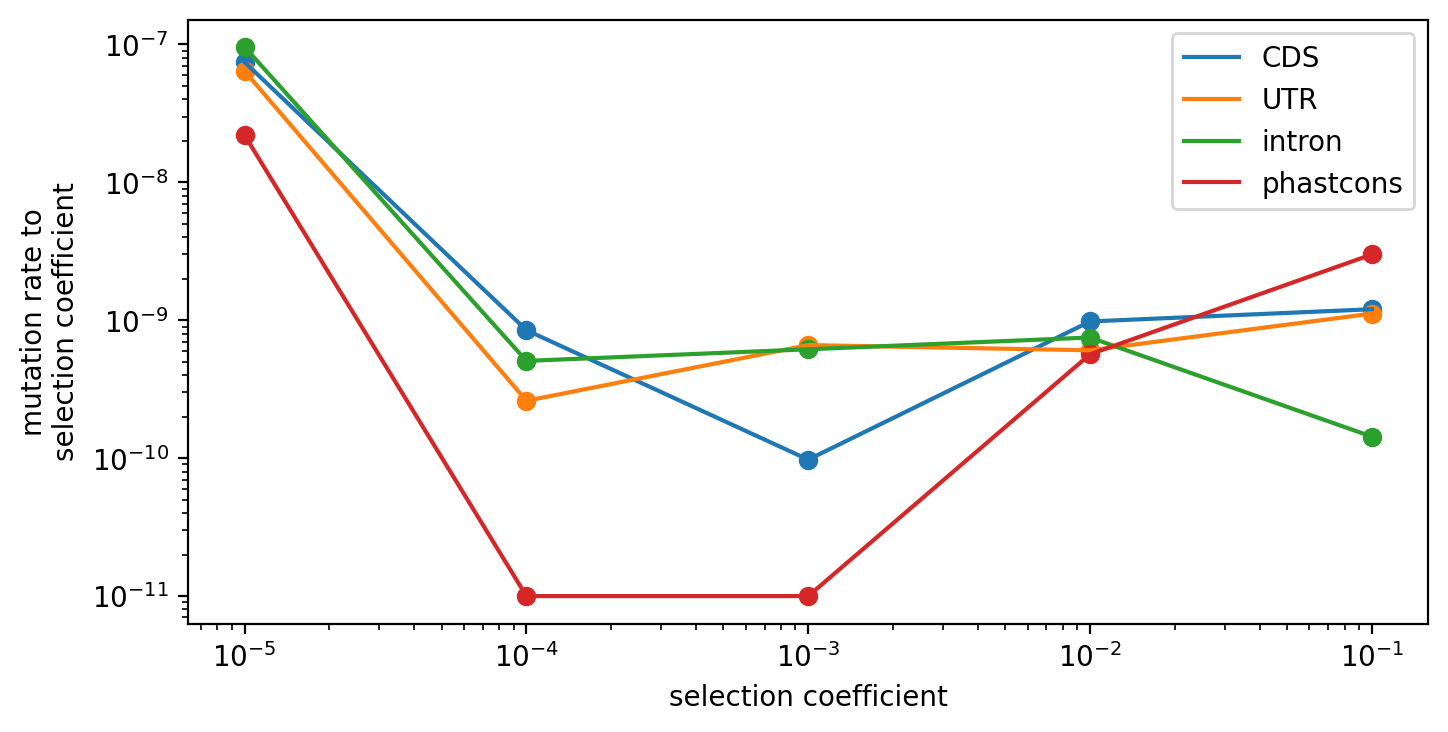

In [62]:
feats = {i: k for k, i in m.segments.feature_map.items()}
prop = mleBp.mle_W /mleBp.mle_W.sum(axis=0)
use_prop = False
for i in range(mleBp.mle_W.shape[1]):
    if use_prop:
        plt.plot(m.t, prop[:, i], label=f"{feats[i]}")
        plt.scatter(m.t, prop[:, i])
    else:
        plt.plot(m.t, mleBp.mle_W[:, i], label=f"{feats[i]}")
        plt.scatter(m.t, mleBp.mle_W[:, i])
plt.semilogy()
plt.legend()
plt.semilogx()
plt.xlabel('selection coefficient')
plt.ylabel('mutation rate to\nselection coefficient')

In [149]:
m.segments.feature_map

{'exon': 0, 'phastcons': 1}

In [72]:
tabulate(mleB.thetas_.mean(axis=0)[1:].reshape((4, 2)))

ValueError: cannot reshape array of size 15 into shape (4,2)

In [16]:
def meanscale(x):
    return x/np.nanmean(x)

ERROR! Session/line number was not unique in database. History logging moved to new session 1703
using neutral masks...
using accessibility masks...


AssertionError: InterpolatedMLE.theta_ is not set, call fit() first

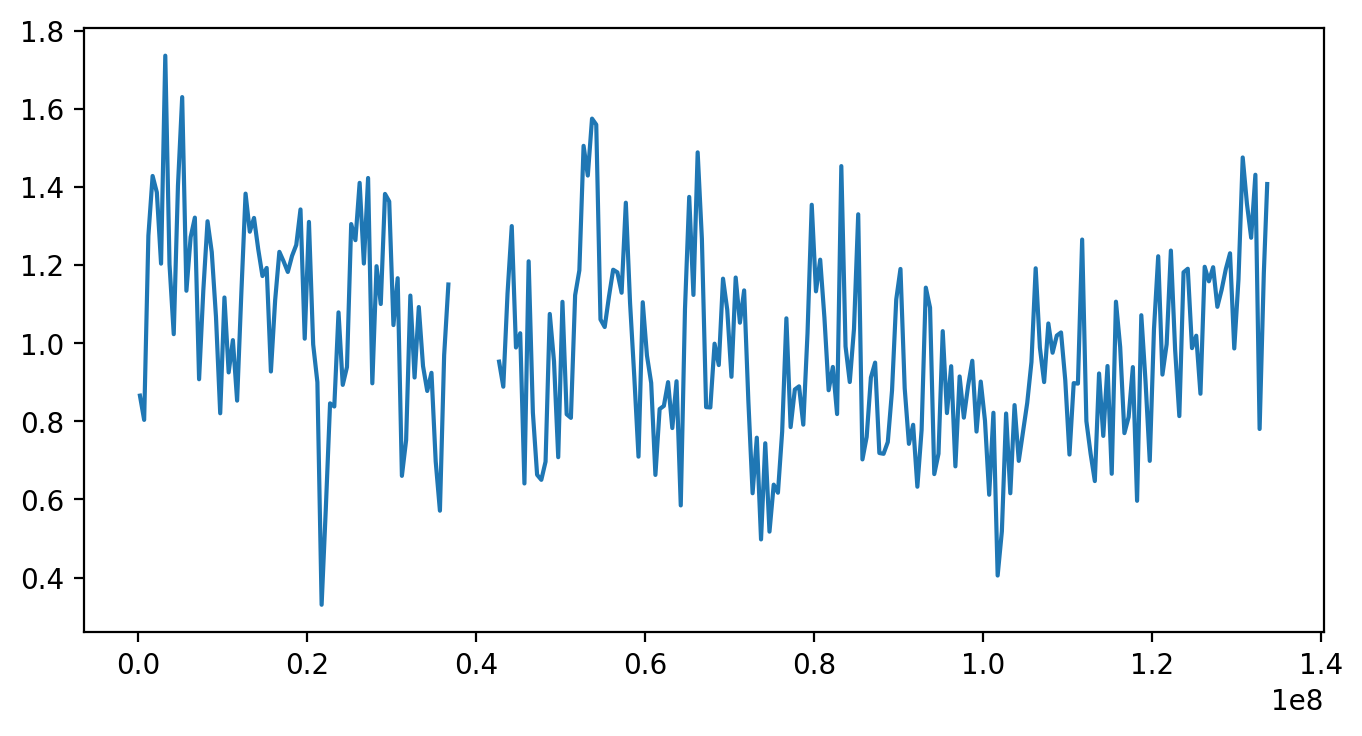

In [17]:
x, y = gd.bin_pi(5e5, filter_accessible=True, filter_neutral=True)[1]['chr10'].pairs
plt.plot(x, meanscale(y))

plt.plot(bins.midpoints['chr10'], meanscale(mleB.predict()), c='r', zorder=10)
plt.plot(bins.midpoints['chr10'], meanscale(mleBp.predict()), c='g', zorder=10)

pis = mle.predict(all=True)
#for i in range(mle.thetas_.shape[0]):
#    plt.plot(bins.midpoints['chr10'], pis[i, ...], c='0.22', alpha=0.1)



In [140]:
pi_pred_B = mleB.predict()
pi_pred_Bp = mleBp.predict()

In [141]:
n_pairs = Y.sum(axis=1)
pi = np.divide(Y[:, 1], n_pairs, where=(n_pairs!=0), out=np.full(n_pairs.shape[0], np.nan))

In [142]:
def R2(x, y):
    complete_idx = ~(np.isnan(x) | np.isnan(y))
    x = x[complete_idx]
    y = y[complete_idx]
    ssxm, ssxym, _, ssym = np.cov(x, y, bias=True).flat
    return ssxym / np.sqrt(ssxm * ssym)

In [143]:
R2(pi_pred_B, pi), R2(pi_pred_Bp, pi)

(0.5055183565210776, 0.5188016239269463)

In [163]:
np.log(1 - np.exp(np.finfo(float).minexp / np.log2(np.exp(1))))

0.0

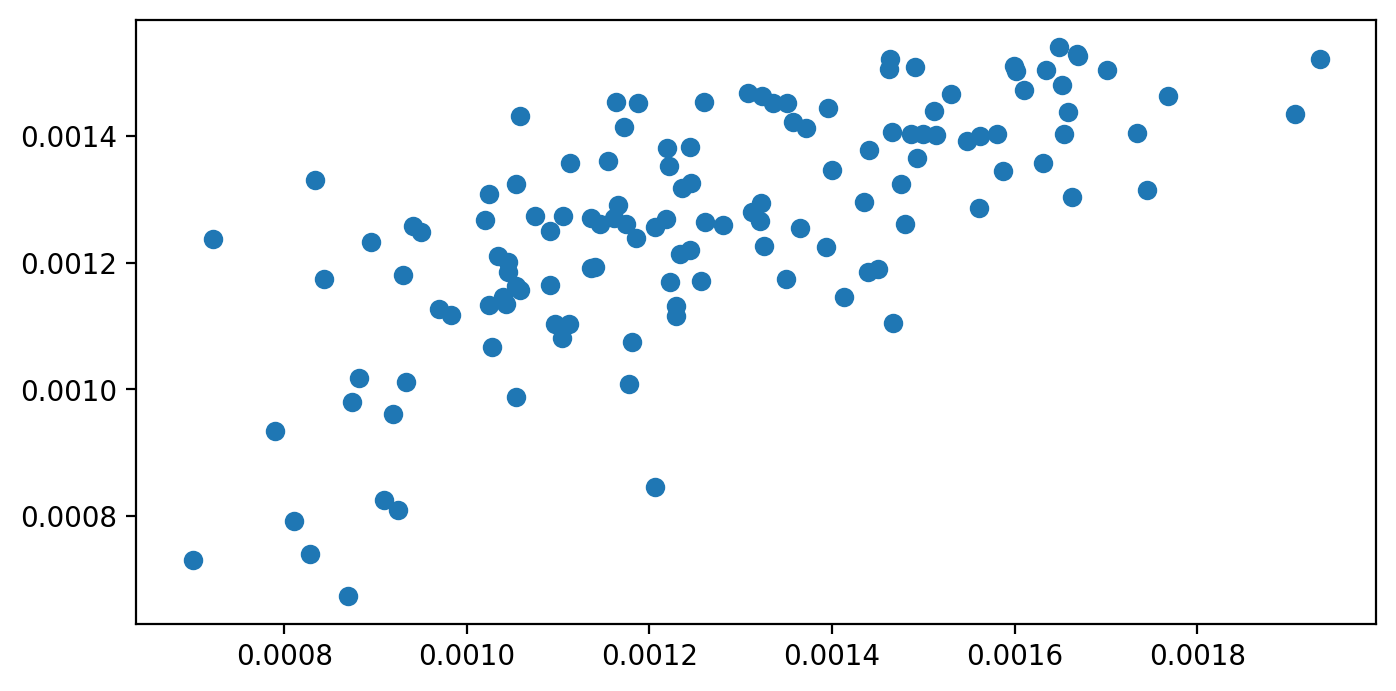

In [163]:
plt.scatter(pi, pi_pred)

In [141]:
np.corrcoef(y[~np.isnan(y)], pi_pred[~np.isnan(y)])

array([[1.        , 0.70241336],
       [0.70241336, 1.        ]])

In [116]:
mleB

MLE (interpolated w): 6 x 7 x 1
  w grid: [1.000e-10 3.981e-10 1.585e-09 6.310e-09 2.512e-08 1.000e-07] (before interpolation)
  t grid: [1.000e-05 4.642e-05 2.154e-04 1.000e-03 4.642e-03 2.154e-02 1.000e-01]
MLEs:
  pi0 = 0.001764
  W = [[1.000e-10]
    [1.000e-10]
    [1.000e-10]
    [1.000e-10]
    [6.109e-09]
    [6.880e-09]
    [8.734e-09]]
 negative log-likelihood: 315232376425.0403

In [117]:
mleBp

MLE (interpolated w): 6 x 7 x 1
  w grid: [1.000e-10 3.981e-10 1.585e-09 6.310e-09 2.512e-08 1.000e-07] (before interpolation)
  t grid: [1.000e-05 4.642e-05 2.154e-04 1.000e-03 4.642e-03 2.154e-02 1.000e-01]
MLEs:
  pi0 = 0.001691
  W = [[8.405e-08]
    [9.254e-08]
    [6.181e-09]
    [8.697e-09]
    [5.106e-09]
    [1.000e-10]
    [8.775e-09]]
 negative log-likelihood: 315213192193.41486

In [328]:
import numba

In [357]:
from bgspy.likelihood import negll, negll_numba

In [358]:
%%timeit
negll_numba(mleBp.theta_, Y, Bp, m.w),

13.7 ms ± 659 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [359]:
%%timeit
negll(mleBp.theta_, Y, Bp, m.w)

135 ms ± 5.44 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [361]:
negll_numba(mleBp.theta_, Y, Bp, m.w), negll(mleBp.theta_, Y, Bp, m.w)

(913624616281.9496, 913624616281.95)

In [319]:
mleBp.mle_W

array([[3.36999430e-08, 1.61469990e-09, 7.88808862e-09, 1.85524786e-08],
       [3.08752505e-10, 6.17946595e-10, 8.37286721e-10, 1.00000000e-10],
       [4.78833712e-10, 2.41454349e-10, 3.91060541e-10, 1.00000000e-10],
       [7.47722698e-10, 4.29517467e-10, 5.00873203e-10, 2.62840114e-09]])

In [108]:
mleB.thetas_.mean(axis=0), mleBp.thetas_.mean(axis=0)

(array([2.68653106e-03, 1.00000000e-10, 1.00000000e-10, 1.00000000e-10,
        4.95176760e-10, 2.22971303e-09, 5.11038049e-09, 1.65620432e-08]),
 array([1.70055522e-03, 5.69398369e-08, 7.65732902e-08, 5.13288339e-08,
        1.43732704e-09, 6.43607810e-10, 1.46868381e-09, 1.55566260e-08]))

In [112]:
mleB.mle_W.sum(), mleBp.mle_W.sum()

(1.8932801935219335e-08, 3.632471335715728e-08)

[]

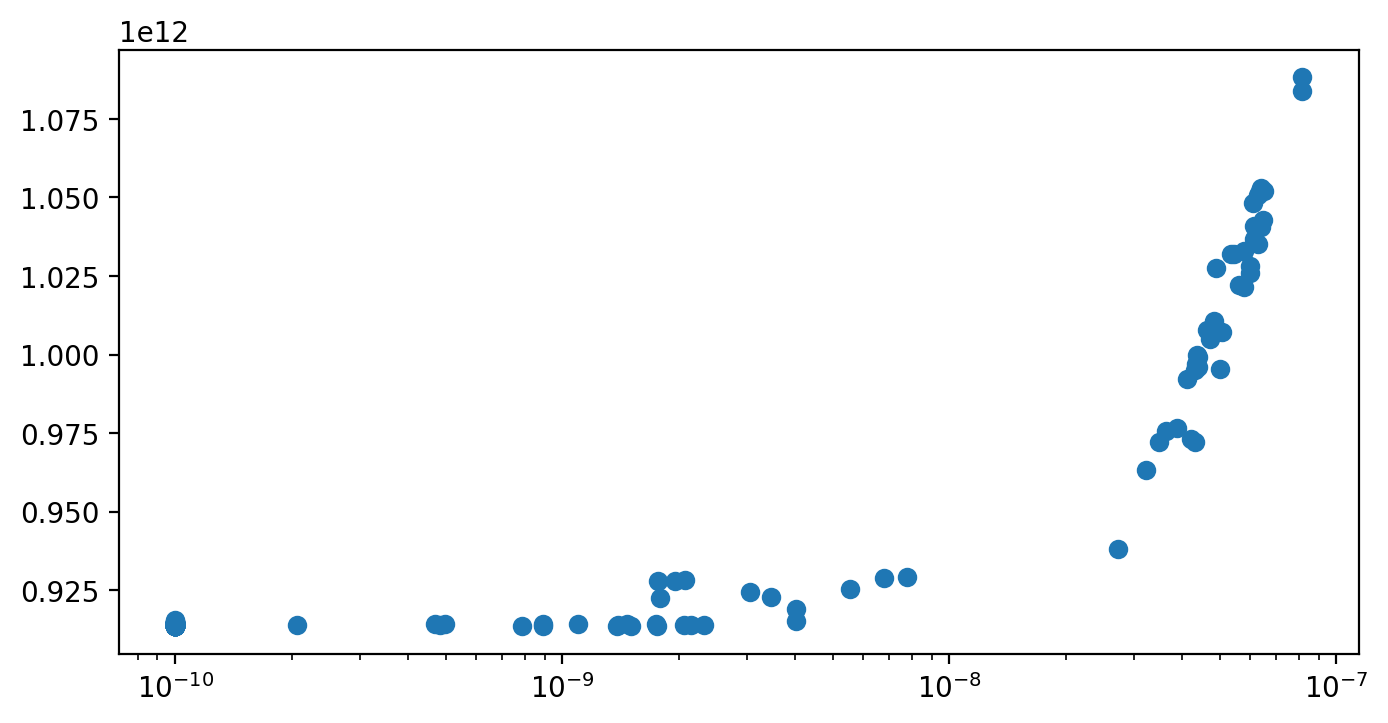

In [428]:
plt.scatter(mleBp.thetas_[:, 16], mleBp.nlls_)
plt.semilogx()
#plt.ylim(0.91e12, 0.925e12)

(913584973690.4689, 913586800862.2434)

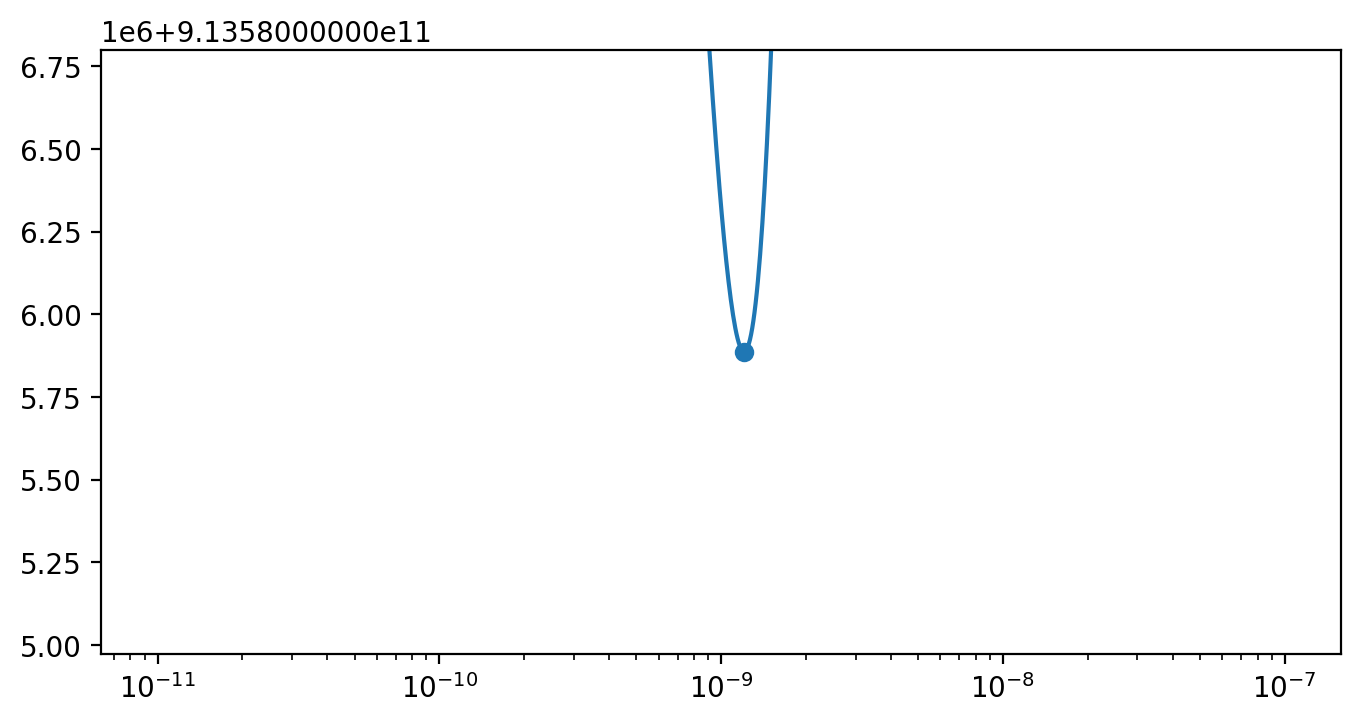

In [144]:
x = np.copy(mleBp.theta_)

res = []
alts = np.logspace(-11, -7, 1000)
Wi = np.arange(1, 13).reshape((4, 3))

for alt in alts:
    x[12] = alt
    res.append(negll_numba(x, Y, Bp, m.w))
    
plt.plot(alts, res)
plt.scatter(alts[np.argmin(res)], res[np.argmin(res)])
plt.semilogx()
plt.ylim(0.999999*np.min(res), np.min(res)*1.000001)

(913607986984.8777, 913609814202.6788)

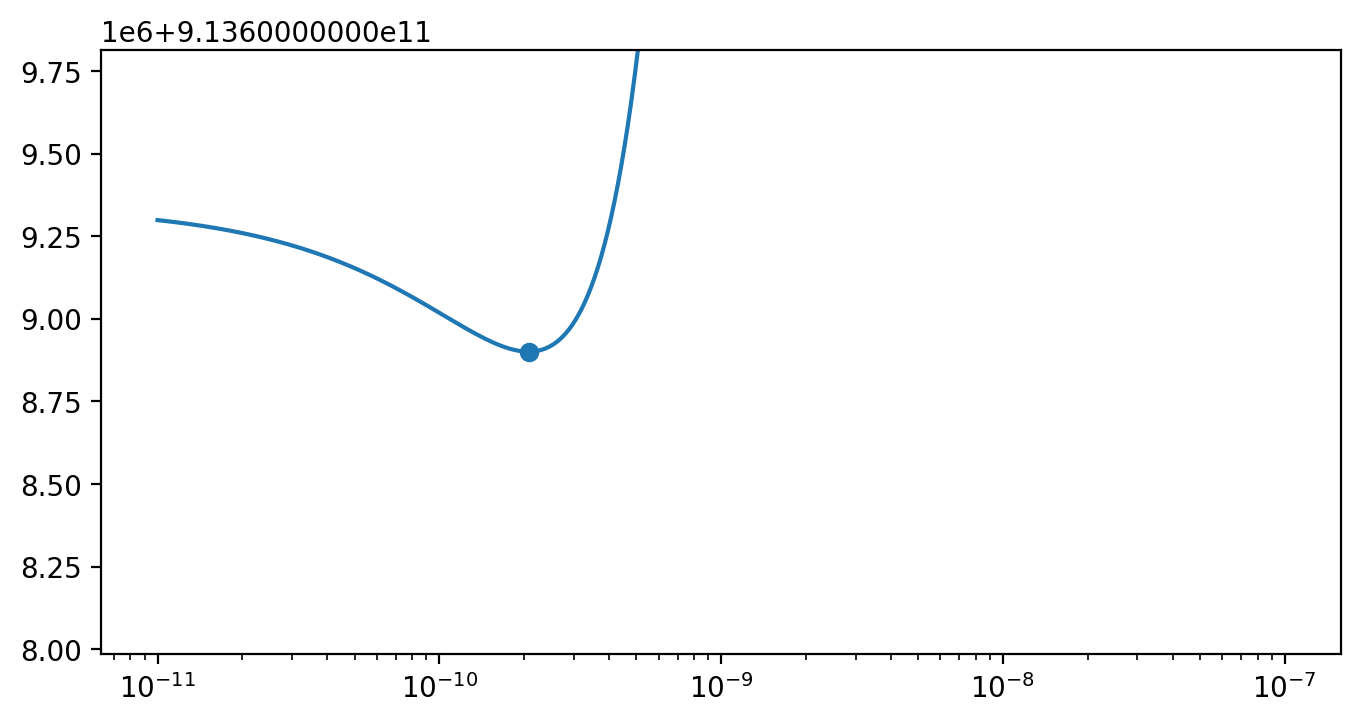

In [135]:
x = np.copy(mleBp.theta_)

res = []
alts = np.logspace(-11, -7, 1000)
Wi = np.arange(1, 13).reshape((4, 3))

for alt in alts:
    x[12] = alt
    res.append(negll_numba(x, Y, Bp, m.w))
    
plt.plot(alts, res)
plt.scatter(alts[np.argmin(res)], res[np.argmin(res)])
plt.semilogx()
plt.ylim(0.999999*np.min(res), np.min(res)*1.000001)

In [90]:
mleBp.mle_W

array([[6.90521589e-09, 6.48376016e-09, 3.98241354e-08],
       [1.52770666e-10, 5.03188410e-11, 9.01215713e-11],
       [1.95296546e-10, 1.06676750e-10, 2.30567085e-10],
       [1.70939337e-10, 2.60831630e-10, 2.33476164e-10],
       [3.94436696e-09, 2.52853612e-09, 1.73215550e-09]])

In [95]:
np.arange(1, 13).reshape((4, 3))

array([[ 1,  2,  3],
       [ 4,  5,  6],
       [ 7,  8,  9],
       [10, 11, 12]])

In [501]:
bps = (g.segments.lengths[:, None] * g.segments.F).sum(axis=0)
bps / bps.sum()

array([0.0286892 , 0.01034282, 0.00757465, 0.95339333])

In [480]:
wopt

array([[2.20388268e-10, 2.83584787e-10, 2.55601873e-10, 3.37011217e-08],
       [1.00000000e-10, 1.00000000e-10, 1.00000000e-10, 1.00000000e-10],
       [2.60632369e-10, 1.00000000e-10, 1.00000000e-10, 2.22480467e-10],
       [2.26802133e-10, 1.01064185e-10, 2.50947480e-10, 1.94755219e-09]])

In [303]:
np.arange(mleBp.theta_.size)[1:].reshape(4, 4)

array([[ 1,  2,  3,  4],
       [ 5,  6,  7,  8],
       [ 9, 10, 11, 12],
       [13, 14, 15, 16]])

In [289]:
mle = mleBp
#pgrid = np.array([mle.theta_[0], 1e-10, 1e-10, 1e-10, 1e-10, 1e-10, np.nan, np.nan])
pgrid = np.copy(mle.theta_)
pgrid[0] = np.nan
pgrid[6] = np.nan
grid, thetas, nlls = mle.profile_likelihood(Y, pgrid, nmesh=[51, None, None, None, None, None, 50, None])

cmap = mpl.cm.get_cmap('viridis_r')
p1, p2 = 0, 6

x, y, z = grid[p1], grid[p2], nlls.reshape((51, 50))
#x, y, z = np.log10(x), np.log10(y), np.log10(z)

#cmap = mpl.cm.get_cmap('viridis_r')

fig, ax = plt.subplots(figsize=(6, 6))
pm = ax.pcolormesh(x, y, z.T, cmap=cmap, norm=mpl.colors.LogNorm(vmin=np.quantile(z, 0.), vmax=z.max()))
ax.scatter(np.log10(mle.theta_[p1]), np.log10(mle.theta_[p2]), c='r')
cs = ax.contour(x, y, z.T, 10, colors='0.44', linestyles='dashed', linewidths=0.8, alpha=0.4)
for i in range(mle.thetas_.shape[0]):
    ax.scatter(mle.thetas_[i, p1], mle.thetas_[i, p2], s=8, c='0.22')
ax.clabel(cs, inline=True, fontsize=10)
plt.colorbar(pm)
plt.xlabel('$\pi_0$')
plt.ylabel('$w_{5, 0}$')
plt.loglog()

IndexError: list index out of range

[]

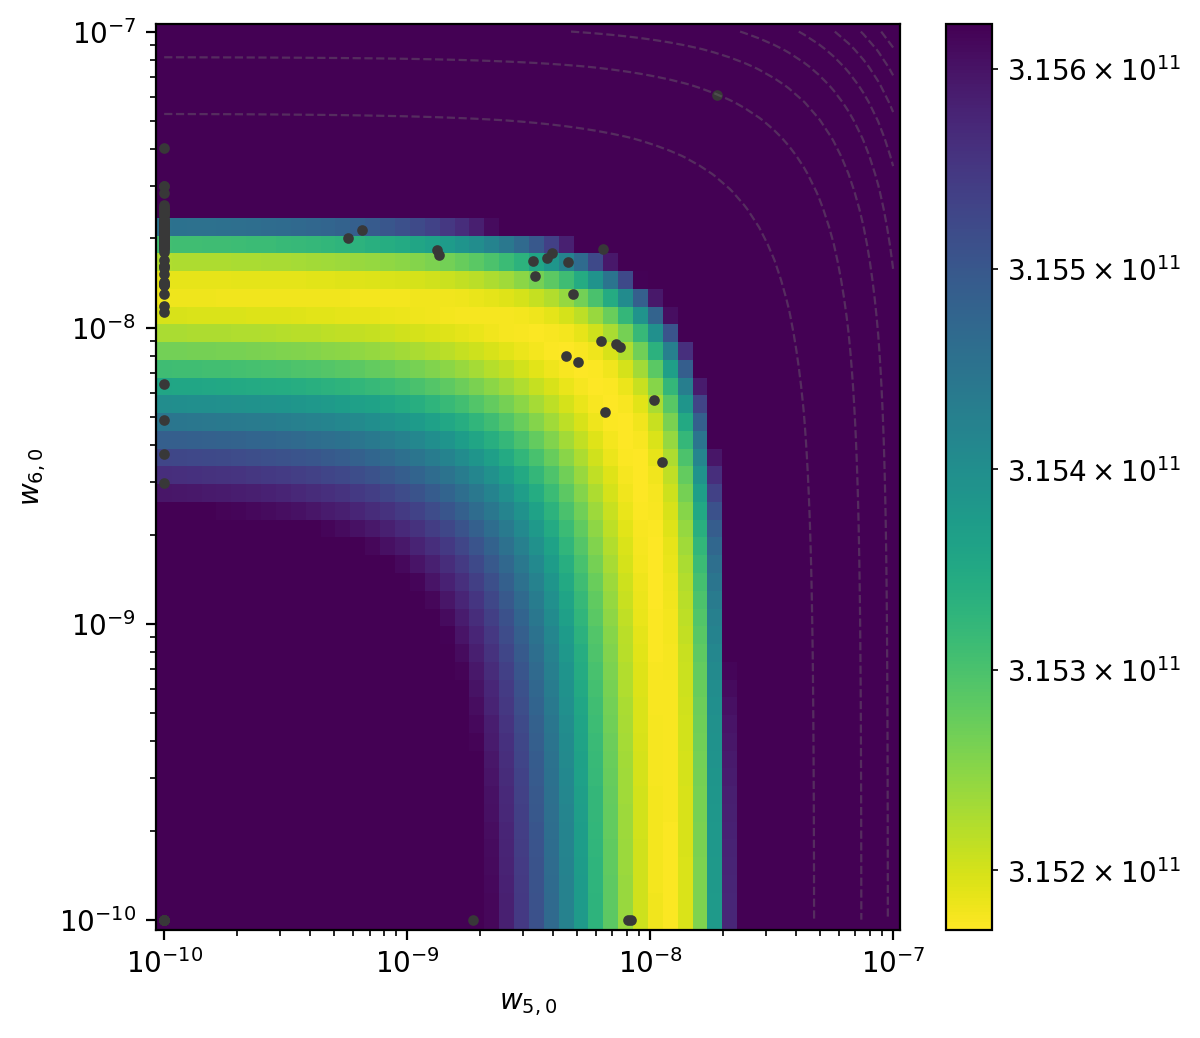

In [57]:
#pgrid = np.array([mle.theta_[0], 1e-10, 1e-10, 1e-10, 1e-10, 1e-10, np.nan, np.nan])
pgrid = np.copy(mle.theta_)
pgrid[6:8] = np.nan
grid, thetas, nlls = mle.profile_likelihood(Y, pgrid, nmesh=[None, None, None, None, None, None, 50, 51])

x, y, z = grid[6], grid[7], nlls.reshape((50, 51))
#x, y, z = np.log10(x), np.log10(y), np.log10(z)

cmap = mpl.cm.get_cmap('viridis_r')

# note on transpose: this is because the number of columns of C must match number of elements of x
fig, ax = plt.subplots(figsize=(6, 6))
pm = ax.pcolormesh(x, y, z.T, cmap=cmap, norm=mpl.colors.LogNorm(vmin=np.quantile(z, 0.), vmax=np.quantile(z, 0.4)))
ax.scatter(np.log10(mle.theta_[6]), np.log10(mle.theta_[7]))
cs = ax.contour(x, y, z.T, 10, colors='0.44', linestyles='dashed', linewidths=0.8, alpha=0.4)
for i in range(mle.thetas_.shape[0]):
    ax.scatter(mle.thetas_[i, 6], mle.thetas_[i, 7], s=8, c='0.22')
ax.clabel(cs, inline=True, fontsize=10)
plt.colorbar(pm)
plt.xlabel('$w_{5, 0}$')
plt.ylabel('$w_{6, 0}$')
plt.loglog()